In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import country_converter as coco

In [19]:
df = pd.read_csv("gn_analysis_2023-05-12-0949.csv")
df.head()

,ip,classification,first_seen,last_seen,actor,spoofable,asn,category,country,country_code,...,city,organization,rdns,tor,os,tags,ja3,scans,paths,useragents
0,159.223.59.102,unknown,2023-04-13,2023-04-13,unknown,False,AS14061,hosting,Singapore,SG,...,Singapore,"DigitalOcean, LLC",NaN,False,unknown,Python Requests Client|Web Crawler,NaN,80/TCP,/,python-requests/2.18.4
1,45.131.46.124,unknown,2021-09-15,2023-04-24,unknown,False,AS212913,hosting,Russia,RU,...,Moscow,FOP Hornostay Mykhaylo Ivanovych,host.sq,False,Windows 7/8,Web Crawler,NaN,80/TCP|81/TCP|82/TCP|83/TCP|84/TCP|85/TCP|86/T...,/,NaN
2,193.35.18.243,malicious,2023-04-07,2023-04-24,unknown,False,AS202685,business,Netherlands,NL,...,Hopel,Aggros Operations Ltd.,243.18.35.193.pfcloud.io,False,Linux 3.11+,ADB Attempt|Carries HTTP Referer|Generic IoT B...,NaN,22/TCP|23/TCP|80/TCP|81/TCP|443/TCP|2222/TCP|5...,/HNAP1/|/,Mozila/5.0|
3,35.183.8.167,malicious,2023-04-22,2023-04-23,unknown,False,AS16509,hosting,Canada,CA,...,Montréal,"Amazon.com, Inc.",ec2-35-183-8-167.ca-central-1.compute.amazonaw...,False,Linux 2.2.x-3.x (Embedded),ENV Crawler|Web Crawler|ZMap Client,NaN,80/TCP,/.env,Mozilla/5.0 zgrab/0.x
4,54.226.215.6,malicious,2023-01-12,2023-04-23,unknown,False,AS14618,hosting,United States,US,...,Ashburn,"Amazon.com, Inc.",ec2-54-226-215-6.compute-1.amazonaws.com,False,Linux 2.2.x-3.x (Embedded),ENV Crawler|Web Crawler|ZMap Client,NaN,80/TCP,/.env,Mozilla/5.0 zgrab/0.x


In [20]:
# Setting the path to the shapefile
SHAPEFILE = 'worldmap/ne_10m_admin_0_countries.shp'
# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]
# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

,country,country_code,geometry
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."


In [17]:
# Next, we need to ensure that our data matches with the country codes.
iso3_codes = geo_df['country'].to_list()
# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list
# There are some countries for which the converter could not find a country code.
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)
geo_df.head(3)

,country,country_code,geometry,iso2_code
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",ID
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MY
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",CL


In [56]:
df1 = df.groupby(["country"]).size().reset_index(name='frequency')
# Merge the two dataframes
merged_df = pd.merge(left=geo_df, right=df1, how='left', left_on='country', right_on='country')
#Create the indicator values
merged_df['frequency'].fillna(0, inplace=True)
merged_df.head(3)


,country,country_code,geometry,frequency
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",1.0
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",-1.0
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",-1.0


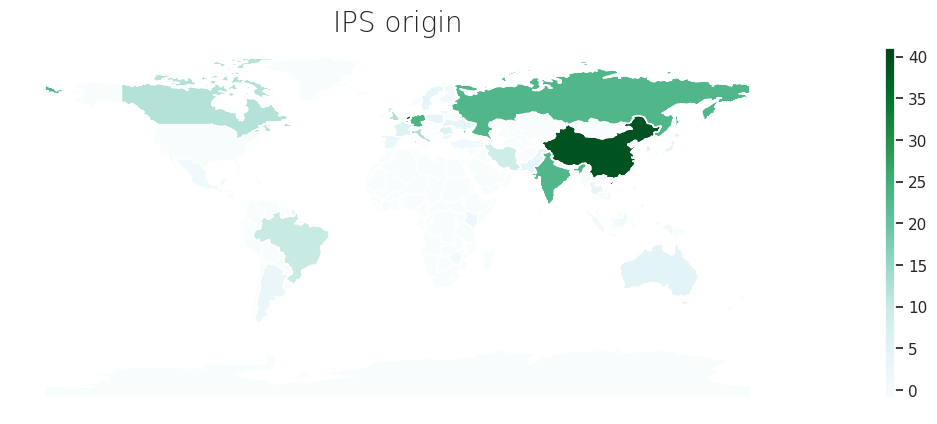

In [59]:
# Show the data
# Plot the map
title = 'IPS origin'
col = 'frequency'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
cmap = 'BuGn'

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axis('off')
merged_df.plot(column=col, ax=ax, linewidth=1, cmap=cmap, edgecolor='white')
ax.set_title(title, fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([1, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)

                  country  frequency
43          United States        163
26            Netherlands         41
9                   China         39
14                Germany         24
33                 Russia         23
16                  India         23
4                 Belgium         22
42         United Kingdom         13
19                  Italy         13
15              Hong Kong         12
8                  Canada         12
5                  Brazil         10
34              Singapore         10
18                   Iran          9
35            South Korea          6
32                Romania          6
13                 France          6
20                  Japan          5
2               Australia          5
31                 Poland          4
39               Thailand          4
37                 Sweden          4
41                Ukraine          4
27               Pakistan          4
38            Switzerland          3
36                  Spain          3
6

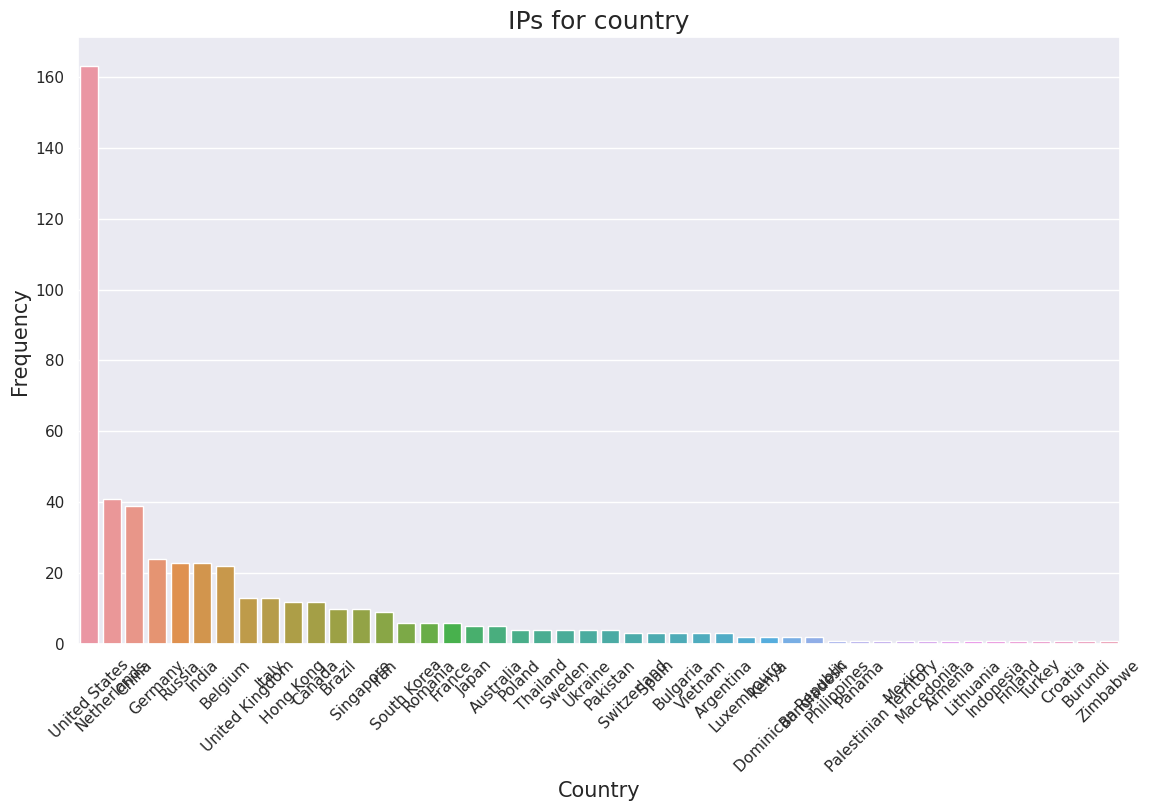

In [4]:
# country counter
sns.set(rc={'figure.figsize':(11.7,8.27)})
df1 = df.groupby(["country"]).size().reset_index(name='frequency')
print (df1.sort_values('frequency',ascending = False))
g = sns.barplot(x='country',  y="frequency", data=df1, order=df1.sort_values('frequency',ascending = False).country)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
# set labels
plt.xlabel("Country", size=15)
plt.ylabel("Frequency", size=15)
plt.title("IPs for country", size=18)
plt.tight_layout()

                                      organization  frequency
28                               DigitalOcean, LLC         47
6                                 Amazon.com, Inc.         20
11                  CHINA UNICOM China169 Backbone         14
37                                      Google LLC         14
39        Hong Kong Zhengxing Technology Co., Ltd.          7
..                                             ...        ...
46                         J.R da Silva Almeida-ME          1
45   Irádio Comercio e Manutenção de Maquinas LTDA          1
43                                Intersvyaz-2 JSC          1
41                           IT4 Polska Sp. z o.o.          1
104                        aamra networks limited,          1

[105 rows x 2 columns]


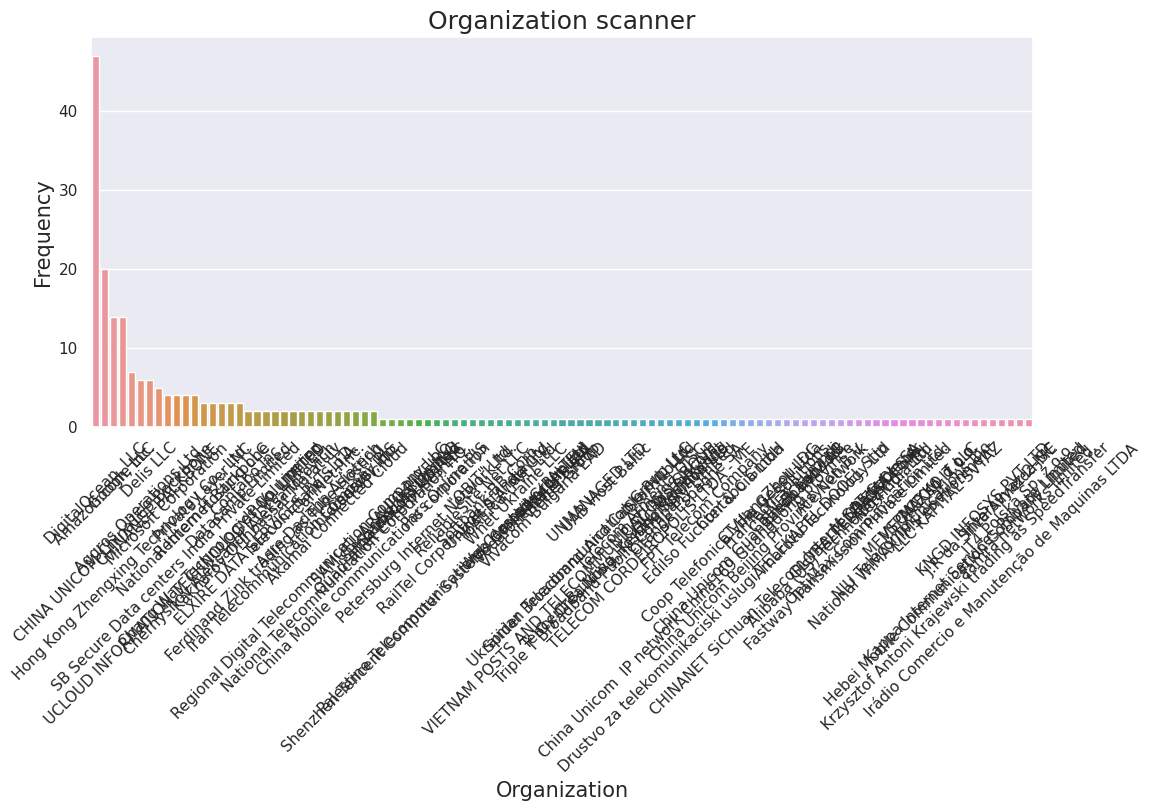

In [61]:
# country counter
sns.set(rc={'figure.figsize':(11.7,8.27)})
df2 = df[df["classification"] == 'malicious']
df2 = df2.groupby(["organization"]).size().reset_index(name='frequency')
g = sns.barplot(x='organization',  y="frequency", data=df2, order=df2.sort_values('frequency',ascending = False).organization)
print (df2.sort_values('frequency',ascending = False))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
# set labels
plt.xlabel("Organization", size=15)
plt.ylabel("Frequency", size=15)
plt.title("Organization scanner", size=18)
plt.tight_layout()